In [0]:
# matplotlib 설정
from matplotlib import pyplot as plt
from matplotlib import rc
import numpy as np

%matplotlib inline

# mac OS 에서 한글이 깨진다면 참고.
# rc('font', family = 'AppleGothic')
# plt.rcParams['axes.unicode_minus'] = False

# LightGBM

- LightGBM 역시 사이킷런에서 제공하지 않기 떄문에 별도의 설치가 필요하다.  
- https://lightgbm.readthedocs.io/en/latest/index.html (LightGBM 공식문서)를 참고하여 설치

- LightGBM은 XGBoost보다 더 빠른 연산이 가능하고 메모리도 적게 사용한다 그러한 측면에서 대용량 데이터 셋에서 효율적이다. 그러나 너무 작은 데이터 셋에서는 과적합 될 우려가 높으니 주의하자.

In [0]:
import lightgbm as lgb
lgb_model = lgb.LGBMClassifier( num_leaves= 200 )

### LightGBM의 파라미터
- xgboost의 파라미터와 거의 동일하다.  
- max_depth : 트리의 깊이를 조정하는 파라미터  
- n_estimators : 반복할 결정 트리의 개수  
- learning_rate : 학습기 마다 가중치를 얼마나 줄 것인지를 설정하는 파라미터  
- boosting_type : xgboost의 booster파라미터와 같은 역할을 하지만 지원하는 모델이 다르다, gbdt(Gradient Boosted Decision Trees), rf(Random Forest), dart, goss(Gradient-based One-Sied Sampling)가 있다.  
    - goss는 계산속도를 줄여 주지만 예측력에서 손실이 있을 수 있다.  
- reg_alpha : L1 규제  
- reg_lambda : L2 규제

In [0]:
lgb_model

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=200, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [0]:
import pandas as pd
raw_data = pd.read_csv('train_0407.csv') ######################################
raw_data.fillna(0, inplace=True)
# raw_data["p0_species"] = raw_data['p0_species'].str.replace( 'T' , '0' ).replace( 'Z' , '1' ).replace('P'  , '2')
# raw_data["p1_species"] = raw_data['p1_species'].str.replace( 'T' , '0' ).replace( 'Z' , '1' ).replace('P'  , '2')
raw_data.drop( columns = 'game_id' , inplace = True )
# raw_data['p0_species'] = raw_data['p0_species'].astype( 'float64' )
# raw_data['p1_species'] = raw_data['p1_species'].astype( 'float64' )
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38872 entries, 0 to 38871
Data columns (total 38 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   sep_time              38872 non-null  float64
 1   p0_Ability            38872 non-null  float64
 2   p1_Ability            38872 non-null  float64
 3   p0_AddToControlGroup  38872 non-null  float64
 4   p1_AddToControlGroup  38872 non-null  float64
 5   p0_Camera             38872 non-null  float64
 6   p1_Camera             38872 non-null  float64
 7   p0_ControlGroup       38872 non-null  float64
 8   p1_ControlGroup       38872 non-null  float64
 9   p0_GetControlGroup    38872 non-null  float64
 10  p1_GetControlGroup    38872 non-null  float64
 11  p0_Right Click        38872 non-null  float64
 12  p1_Right Click        38872 non-null  float64
 13  p0_Selection          38872 non-null  float64
 14  p1_Selection          38872 non-null  float64
 15  p0_SetControlGroup 

# 새 섹션

In [0]:
# raw_data = raw_data.dropna(axis = 0 )
#raw_data = raw_data.fillna( 0 )
# raw_data = raw_data.replace( float('inf') , 0 )
# raw_data = raw_data.round(3)
# raw_data = raw_data.astype('float64')
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 325034 entries, 0 to 325033
Data columns (total 22 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   sep_time                 325034 non-null  float64
 1   p0_P                     325034 non-null  int64  
 2   p1_P                     325034 non-null  int64  
 3   p0_T                     325034 non-null  int64  
 4   p1_T                     325034 non-null  int64  
 5   p0_Z                     325034 non-null  float64
 6   p1_Z                     325034 non-null  float64
 7   delta_Ability            325034 non-null  float64
 8   delta_AddToControlGroup  325034 non-null  float64
 9   delta_Camera             325034 non-null  float64
 10  delta_ControlGroup       325034 non-null  float64
 11  delta_GetControlGroup    325034 non-null  float64
 12  delta_Right Click        325034 non-null  float64
 13  delta_Selection          325034 non-null  float64
 14  delt

In [0]:
import numpy as np
np.where(raw_data.values >= np.finfo( np.float64 ).max )

(array([], dtype=int64), array([], dtype=int64))

In [0]:
! pip install bayesian-optimization

In [0]:
import pandas as pd                         # 데이터 분석 라이브러리
import numpy as np                          # 계산 라이브러리
from tqdm import tqdm                       # 진행바
from sklearn.metrics import roc_auc_score   # AUC 스코어 계산
from sklearn.model_selection import KFold   # K-fold CV    
from bayes_opt import BayesianOptimization  # 베이지안 최적화 라이브러리  
from functools import partial               # 함수 변수 고정
import lightgbm as lgb                      # LightGBM 라이브러리
import warnings                             
warnings.filterwarnings("ignore") 

from sklearn.model_selection import train_test_split



raw_data = pd.read_csv('tmp.csv')
raw_data = raw_data.drop(columns = 'Unnamed: 0')#########################################
label =raw_data.pop('winner')
# raw_data.pop('delta_Camera')
raw_data.drop( columns = 'game_id' , inplace = True )
raw_data = raw_data.fillna(0)
raw_data = raw_data.replace( float('inf') , 0 )




x_train = raw_data 
y_train = label

# x_train, x_test, y_train, y_test = train_test_split( input_data , output_data, 
#                                                    shuffle = True , stratify = output_data , test_size = 0.3 )



def lgb_cv(num_leaves, learning_rate, n_estimators, subsample, colsample_bytree, reg_alpha, reg_lambda, x_data=None, y_data=None, n_splits=5, output='score'):
    score = 0
    kf = KFold(n_splits=n_splits)
    models = []
    for train_index, valid_index in kf.split(x_data):
        x_train, y_train = x_data.iloc[train_index], y_data[train_index]
        x_valid, y_valid = x_data.iloc[valid_index], y_data[valid_index]
        
        model = lgb.LGBMClassifier(
            num_leaves = int(num_leaves), 
            learning_rate = learning_rate, 
            n_estimators = int(n_estimators), 
            subsample = np.clip(subsample, 0, 1), 
            colsample_bytree = np.clip(colsample_bytree, 0, 1), 
            reg_alpha = reg_alpha, 
            reg_lambda = reg_lambda,
        )
        
        model.fit(x_train, y_train)
        models.append(model)
        
        pred = model.predict_proba(x_valid)[:, 1]
        true = y_valid
        score += roc_auc_score(true, pred)/n_splits
    
    if output == 'score':
        return score
    if output == 'model':
        return models
# 모델과 관련없는 변수 고정
func_fixed = partial(lgb_cv, x_data=x_train, y_data=y_train, n_splits=5, output='score') 
# 베이지안 최적화 범위 설정
lgbBO = BayesianOptimization(
    func_fixed, 
    {
        'num_leaves': (16, 1024),        # num_leaves,       범위(16~1024)
        'learning_rate': (0.0001, 0.1),  # learning_rate,    범위(0.0001~0.1)
        'n_estimators': (16, 1024),      # n_estimators,     범위(16~1024)
        'subsample': (0, 1),             # subsample,        범위(0~1)
        'colsample_bytree': (0, 1),      # colsample_bytree, 범위(0~1)
        'reg_alpha': (0, 10),            # reg_alpha,        범위(0~10)
        'reg_lambda': (0, 50),           # reg_lambda,       범위(0~50)
    }, 
    random_state=343                # 시드 고정
)
lgbBO.maximize(init_points=5, n_iter=10)


params = lgbBO.max['params']
models = lgb_cv(
    params['num_leaves'], 
    params['learning_rate'], 
    params['n_estimators'], 
    params['subsample'], 
    params['colsample_bytree'], 
    params['reg_alpha'], 
    params['reg_lambda'], 
    x_data=x_train, y_data=y_train, n_splits=5, output='model')

preds = []
for model in models:
    train_result = model.score(x_train, y_train)
    test_result  = model.score(x_test, y_test)

    preds.append(pred)
pred = np.mean(preds, axis=0)

|   iter    |  target   | colsam... | learni... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        |  0.6116   |  0.07506  |  0.06464  |  677.6    |  439.4    |  2.39     |  46.06    |  0.9318   |
|  2        |  0.6136   |  0.1086   |  0.01355  |  192.9    |  744.3    |  0.7443   |  33.08    |  0.6856   |
|  3        |  0.5947   |  0.2428   |  0.0999   |  980.4    |  881.6    |  1.735    |  42.89    |  0.8479   |


In [0]:
dict(zip(list(x_train.columns) , list(model.feature_importances_)))

{'Unnamed: 0': 149,
 'p0_Ability': 125,
 'p0_AddToControlGroup': 12,
 'p0_Camera': 39,
 'p0_ControlGroup': 1,
 'p0_GetControlGroup': 156,
 'p0_P': 11,
 'p0_Right Click': 85,
 'p0_Selection': 84,
 'p0_SetControlGroup': 17,
 'p0_T': 64,
 'p0_Z': 3,
 'p0_attack': 9,
 'p0_build': 2,
 'p0_gas': 51,
 'p0_mineral': 67,
 'p0_unit': 8,
 'p0_upgrade': 9,
 'p0_worker': 38,
 'p1_Ability': 156,
 'p1_AddToControlGroup': 14,
 'p1_Camera': 54,
 'p1_ControlGroup': 0,
 'p1_GetControlGroup': 134,
 'p1_Right Click': 77,
 'p1_Selection': 74,
 'p1_SetControlGroup': 47,
 'p1_T': 0,
 'p1_attack': 19,
 'p1_build': 10,
 'p1_gas': 51,
 'p1_mineral': 52,
 'p1_unit': 9,
 'p1_upgrade': 1,
 'p1_worker': 48,
 'sep_time': 41}

In [0]:
models

# x_train, x_test, y_train, y_test = train_test_split( input_data , output_data, 
#                                                     shuffle = True , stratify = output_data , test_size = 0.3 )

features = [] 

for model in models:
  model.fit( x_train , y_train)
  print(model.feature_importances_)
  print(len(model.feature_importances_))

[149  41 125 156  12  14  39  54   1   0 156 134  85  77  84  74  17  47
  11  64   0   3  38  48   9  19   2  10   8   9   9   1  67  52  51  51]
36
[149  41 125 156  12  14  39  54   1   0 156 134  85  77  84  74  17  47
  11  64   0   3  38  48   9  19   2  10   8   9   9   1  67  52  51  51]
36
[149  41 125 156  12  14  39  54   1   0 156 134  85  77  84  74  17  47
  11  64   0   3  38  48   9  19   2  10   8   9   9   1  67  52  51  51]
36
[149  41 125 156  12  14  39  54   1   0 156 134  85  77  84  74  17  47
  11  64   0   3  38  48   9  19   2  10   8   9   9   1  67  52  51  51]
36
[149  41 125 156  12  14  39  54   1   0 156 134  85  77  84  74  17  47
  11  64   0   3  38  48   9  19   2  10   8   9   9   1  67  52  51  51]
36


In [0]:

# params = lgbBO.max['params']
# models = lgb_cv(
#     params['num_leaves'], 
#     params['learning_rate'], 
#     params['n_estimators'], 
#     params['subsample'], 
#     params['colsample_bytree'], 
#     params['reg_alpha'], 
#     params['reg_lambda'], 
#     x_data=x_train, y_data=y_train, n_splits=5, output='model')

# # preds = []
# for model in models:
#     train_result = model.score(x_train, y_train)
#     test_result  = model.score(x_test, y_test)

#     preds.append(pred)
# pred = np.mean(preds, axis=0)

In [0]:
# models
 x_train, x_test, y_train, y_test = train_test_split( input_data , output_data, 
                                                    shuffle = True , stratify = output_data , test_size = 0.3 )
preds_ = []
for model in models:
    train_score = model.score(x_train, y_train)
    test_score  = model.score(x_test, y_test)

    preds_.append([train_score , test_score ] )
preds_

[[0.723888276368982, 0.7220888355342137],
 [0.7265711135611908, 0.7261190190361859],
 [0.7282249173098125, 0.7262905162064826],
 [0.7259463432561558, 0.7256045275252958],
 [0.7263506063947078, 0.7256902761104442]]

In [0]:
models

[LGBMClassifier(boosting_type='gbdt', class_weight=None,
                colsample_bytree=0.857458221996557, importance_type='split',
                learning_rate=0.03952540990037578, max_depth=-1,
                min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
                n_estimators=220, n_jobs=-1, num_leaves=31, objective=None,
                random_state=None, reg_alpha=0.9989087512371042,
                reg_lambda=1.2363980579296996, silent=True,
                subsample=0.7721081083134981, subsample_for_bin=200000,
                subsample_freq=0),
 LGBMClassifier(boosting_type='gbdt', class_weight=None,
                colsample_bytree=0.857458221996557, importance_type='split',
                learning_rate=0.03952540990037578, max_depth=-1,
                min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
                n_estimators=220, n_jobs=-1, num_leaves=31, objective=None,
                random_state=None, reg_alpha=0.9989087

In [0]:
x_train

"""
사용할 컬럼들
playtime	p0_species	p1_species	rate_Selection	rate_Ability	rate_Right Click	rate_SetControlGroup	rate_GetControlGroup	rate_AddToControlGroup	rate_ControlGroup	rate_attack	p0_ControlGroup_action	p1_ControlGroup_action	rate_worker	rate_unit	rate_build	rate_upgrade
"""

"""
hyper param

[LGBMClassifier(boosting_type='gbdt', class_weight=None,
                colsample_bytree=0.3499288705863093, importance_type='split',
                learning_rate=0.09568813686487992, max_depth=-1,
                min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
                n_estimators=331, n_jobs=-1, num_leaves=18, objective=None,
                random_state=None, reg_alpha=0.7170364194945167,
                reg_lambda=49.020607201040946, silent=True,
                subsample=0.9449680839770777, subsample_for_bin=200000,
                subsample_freq=0),
 LGBMClassifier(boosting_type='gbdt', class_weight=None,
                colsample_bytree=0.3499288705863093, importance_type='split',
                learning_rate=0.09568813686487992, max_depth=-1,
                min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
                n_estimators=331, n_jobs=-1, num_leaves=18, objective=None,
                random_state=None, reg_alpha=0.7170364194945167,
                reg_lambda=49.020607201040946, silent=True,
                subsample=0.9449680839770777, subsample_for_bin=200000,
                subsample_freq=0),
 LGBMClassifier(boosting_type='gbdt', class_weight=None,
                colsample_bytree=0.3499288705863093, importance_type='split',
                learning_rate=0.09568813686487992, max_depth=-1,
                min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
                n_estimators=331, n_jobs=-1, num_leaves=18, objective=None,
                random_state=None, reg_alpha=0.7170364194945167,
                reg_lambda=49.020607201040946, silent=True,
                subsample=0.9449680839770777, subsample_for_bin=200000,
                subsample_freq=0),
 LGBMClassifier(boosting_type='gbdt', class_weight=None,
                colsample_bytree=0.3499288705863093, importance_type='split',
                learning_rate=0.09568813686487992, max_depth=-1,
                min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
                n_estimators=331, n_jobs=-1, num_leaves=18, objective=None,
                random_state=None, reg_alpha=0.7170364194945167,
                reg_lambda=49.020607201040946, silent=True,
                subsample=0.9449680839770777, subsample_for_bin=200000,
                subsample_freq=0),
 LGBMClassifier(boosting_type='gbdt', class_weight=None,
                colsample_bytree=0.3499288705863093, importance_type='split',
                learning_rate=0.09568813686487992, max_depth=-1,
                min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
                n_estimators=331, n_jobs=-1, num_leaves=18, objective=None,
                random_state=None, reg_alpha=0.7170364194945167,
                reg_lambda=49.020607201040946, silent=True,
                subsample=0.9449680839770777, subsample_for_bin=200000,
                subsample_freq=0)]
"""

In [0]:
# from sklearn.model_selection import train_test_split
# # raw_data = raw_data.drop( columns = 'rate_Ability')
# output_data = raw_data['winner']
# input_data = raw_data.drop(columns = 'winner')

# X_train, X_test, y_train, y_test = train_test_split( input_data , output_data, 
#                                                    shuffle = True , stratify = output_data , test_size = 0.3 )



# lgb_model = lgb.LGBMClassifier(boosting_type='gbdt', class_weight=None,
#                 colsample_bytree=0.3499288705863093, importance_type='split',
#                 learning_rate=0.09568813686487992, max_depth=-1,
#                 min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
#                 n_estimators=331, n_jobs=-1, num_leaves=18, objective=None,
#                 random_state=None, reg_alpha=0.7170364194945167,
#                 reg_lambda=49.020607201040946, silent=True,
#                 subsample=0.9449680839770777, subsample_for_bin=200000,
#                 subsample_freq=0).fit(X_train, y_train)

# # print(i)
# print('train score : {:.3f}'.format(lgb_model.score(X_train, y_train)))
# print('test score : {:.3f}'.format(lgb_model.score(X_test, y_test)))

train score : 0.682
test score : 0.625


In [0]:
### 결과예측
x_test = pd.read_csv('train_0324_allcolumn.csv',index_col='game_id')
preds = []
for model in models:
    pred = model.predict_proba(x_test)[:, 1]
    preds.append(pred)
pred = np.mean(preds, axis=0)

submission = pd.read_csv('sample_submission.csv', index_col=0)
submission['winner'] = submission['winner'] + pred
submission.to_csv('submission_0324_total.csv')
submission.head()

,winner
game_id,
38872,0.640575
38873,0.579141
38874,0.353612
38875,0.234824
38876,0.570745


In [0]:
x_train = np.array(X_train.values)

In [0]:
import keras
from keras.layers import Dense
from keras.models import Sequential
# from keras.models import DropOut


model = Sequential()


model.add(Dense ( 14 , input_shape = ( 16 ,  ) , activation = 'relu'))
model.add(Dense( 64 , activation = 'relu' ))
model.add(Dense( 32 , activation = 'relu' ))
model.add(Dense( 1, activation = 'sigmoid'))

model.compile( loss = 'binary_crossentropy' , optimizer = 'adam' , metrics =['accuracy'])

model.summary()

model.fit( x_train, y_train ,epochs =  30 , verbose = 2)

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_69 (Dense)             (None, 14)                238       
_________________________________________________________________
dense_70 (Dense)             (None, 64)                960       
_________________________________________________________________
dense_71 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_72 (Dense)             (None, 1)                 33        
Total params: 3,311
Trainable params: 3,311
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
 - 4s - loss: 0.6946 - acc: 0.5004
Epoch 2/30
 - 3s - loss: 0.6932 - acc: 0.4991
Epoch 3/30
 - 3s - loss: 0.6932 - acc: 0.4972
Epoch 4/30
 - 3s - loss: 0.6932 - acc: 0.5002
Epoch 5/30
 - 3s - loss: 0.6932 - acc: 0.4996
Epoch 6/30
 - 3s - 

KeyboardInterrupt: ignored

- XGBoost와 동일하게 plot_importance로 특성들의 유효성을 확인할 수 있다.

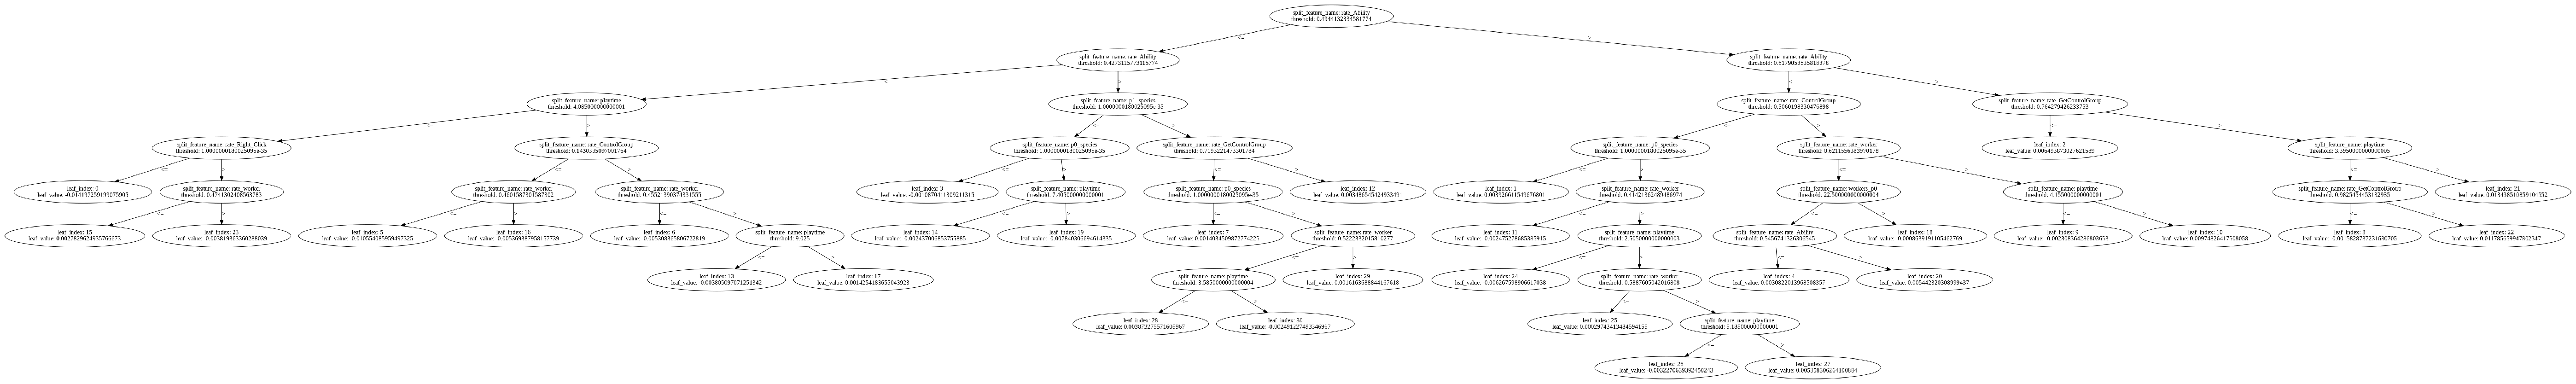

In [0]:
from lightgbm import plot_tree
fig, ax = plt.subplots(figsize = (100, 200))
plot_tree(lgb_model, ax=ax)